## RNN to predict sine wave data
- This notebook, I'll explore RNN's technique to predict time sequence sine wave data
- Also, implement LSTM to optimize the model performance
- Evaluate and compare the model performance
- Forecast sine wave data for the next data points

In [1]:
# import libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### Generate Data 

In [2]:
x = np.linspace(1, 50, 501)

In [3]:
y = np.sin(x)

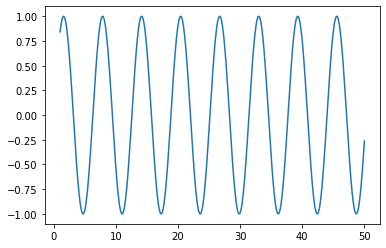

In [4]:
plt.plot(x,y)

In [5]:
# lets create a dataframe
df = pd.DataFrame(data=y, index = x, columns = ['Sine'])
df.head()

,Sine
1.000,0.841471
1.098,0.890298
1.196,0.930582
1.294,0.961936
1.392,0.984058


### Determining train and test data

- Here, there is no as such test data like in other usual cases as the nature of this case is to forecast the next likely event
- So, considering the training data, it contains both the training as well as the test data and will need to use it accordingly based on the time step
- But still we will divide the data into training and test data, where the model training and validation will be done on the training data and the final validation can be done on the test data
- We will need to decide the percentage of data that we want to keep for test, then accordingly we will find out the cut off point in the training data

In [6]:
## lets say we want 10 percent of our data for test
test_percent = 0.1

In [7]:
# find the amount of obervations for the test data, i.e. 10 % of the original data

# total data
len(df)

501

In [8]:
# 10% of total data
len(df) * test_percent

50.1

- So, we will use around 50 samples for test

In [9]:
# getting the cutoff point
len(df) - int(len(df) * test_percent)

451

- So, basically we will use our first 451 samples as the train set and 
- last 50 samples as our test set

In [10]:
train = df.iloc[:451]
test = df.iloc[451:]

In [11]:
train.tail()

,Sine
44.708,0.663661
44.806,0.733667
44.904,0.796632
45.002,0.851952
45.100,0.899097


In [12]:
test.head()

,Sine
45.198,0.937614
45.296,0.967133
45.394,0.987371
45.492,0.998134
45.590,0.999319


In [13]:
len(train), len(test)

(451, 50)

### PreProcessing our data
- Here, we will need to pre-process our data i.e. we will need to scale the data
- by data, meaning both the features and the labels
- labels also, because these labels will be fed in as input to the next time step NN
- So, labels becomes the input to the next layer

In [14]:
# import scaler library
from sklearn.preprocessing import MinMaxScaler

In [15]:
# initialize the scaler object
scaler = MinMaxScaler()

In [16]:
# fit and transform
scaler.fit(train)

train_scaled = scaler.transform(train)
test_scaled = scaler.transform(test)

# Time Series Generator

This class takes in a sequence of data-points gathered at
equal intervals, along with time series parameters such as
stride, length of history, etc., to produce batches for
training/validation.

#### Arguments
    data: Indexable generator (such as list or Numpy array)
        containing consecutive data points (timesteps).
        The data should be at 2D, and axis 0 is expected
        to be the time dimension.
    targets: Targets corresponding to timesteps in `data`.
        It should have same length as `data`.
    length: Length of the output sequences (in number of timesteps).
    sampling_rate: Period between successive individual timesteps
        within sequences. For rate `r`, timesteps
        `data[i]`, `data[i-r]`, ... `data[i - length]`
        are used for create a sample sequence.
    stride: Period between successive output sequences.
        For stride `s`, consecutive output samples would
        be centered around `data[i]`, `data[i+s]`, `data[i+2*s]`, etc.
    start_index: Data points earlier than `start_index` will not be used
        in the output sequences. This is useful to reserve part of the
        data for test or validation.
    end_index: Data points later than `end_index` will not be used
        in the output sequences. This is useful to reserve part of the
        data for test or validation.
    shuffle: Whether to shuffle output samples,
        or instead draw them in chronological order.
    reverse: Boolean: if `true`, timesteps in each output sample will be
        in reverse chronological order.
    batch_size: Number of timeseries samples in each batch
        (except maybe the last one).

In [17]:
# import TimeSeriesGenerator
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [18]:
help(TimeseriesGenerator)

Help on class TimeseriesGenerator in module keras.preprocessing.sequence:

class TimeseriesGenerator(keras.utils.data_utils.Sequence)
 |  TimeseriesGenerator(data, targets, length, sampling_rate=1, stride=1, start_index=0, end_index=None, shuffle=False, reverse=False, batch_size=128)
 |  
 |  Utility class for generating batches of temporal data.
 |  
 |  Deprecated: `tf.keras.preprocessing.sequence.TimeseriesGenerator` does not
 |  operate on tensors and is not recommended for new code. Prefer using a
 |  `tf.data.Dataset` which provides a more efficient and flexible mechanism for
 |  batching, shuffling, and windowing input. See the
 |  [tf.data guide](https://www.tensorflow.org/guide/data) for more details.
 |  
 |  This class takes in a sequence of data-points gathered at
 |  equal intervals, along with time series parameters such as
 |  stride, length of history, etc., to produce batches for
 |  training/validation.
 |  
 |  Arguments:
 |      data: Indexable generator (such as li

### define Generator and necessary parameters

In [19]:
length = 2
batch_size = 1
generator = TimeseriesGenerator(data=train_scaled, # use train data for training and fitting
                                targets=train_scaled, # using train data as it is both the label and the input in diff timesteps
                                length=length,        # Length of the output sequences (in number of timesteps).
                                batch_size=batch_size) # Number of timeseries samples in each batch

In [21]:
generator[0]

(array([[[0.92074163],
         [0.9451555 ]]]),
 array([[0.96529754]]))

In [22]:
test_train, test_target = generator[0]
print(test_train)
print(test_target)

[[[0.92074163]
  [0.9451555 ]]]
[[0.96529754]]


In [25]:
# check our train data
train_scaled[:5]

array([[0.92074163],
       [0.9451555 ],
       [0.96529754],
       [0.98097448],
       [0.99203586]])

- We can see the first two values are used as the training data and the 3rd data will be used as the validation data when length = 2 and batch_size = 1
- Lets check for other combinations

In [28]:
# length = 4
length = 4
batch_size = 1
generator = TimeseriesGenerator(data=train_scaled, # use train data for training and fitting
                                targets=train_scaled, # using train data as it is both the label and the input in diff timesteps
                                length=length,        # Length of the output sequences (in number of timesteps).
                                batch_size=batch_size) # Number of timeseries samples in each batch

In [29]:
test_train, test_target = generator[0]
print(test_train)
print(test_target)

[[[0.92074163]
  [0.9451555 ]
  [0.96529754]
  [0.98097448]]]
[[0.99203586]]


- Now we can see the first 4 values are used as the train data for the first instance and the 5th value will be used as the validation data
- This will keep on moving forward like this

In [31]:
len(generator), len(train_scaled)

(447, 451)

- We have len(generator) as 447 which is len(train_scaled) - length
- this is because, it needs to mapped with the exact number of samples considering the length

In [32]:
# length = 4
length = 4
batch_size = 2
generator = TimeseriesGenerator(data=train_scaled, # use train data for training and fitting
                                targets=train_scaled, # using train data as it is both the label and the input in diff timesteps
                                length=length,        # Length of the output sequences (in number of timesteps).
                                batch_size=batch_size) # Number of timeseries samples in each batch

In [33]:
generator[0]

(array([[[0.92074163],
         [0.9451555 ],
         [0.96529754],
         [0.98097448]],
 
        [[0.9451555 ],
         [0.96529754],
         [0.98097448],
         [0.99203586]]]),
 array([[0.99203586],
        [0.99837554]]))

**One thing to keep in mind always is that depending on the nature of the problem we are trying to solve, we should choose the length. Say e.g. if we are working something related to a yearly event or a monthly event, then we might need to think about setting the length to a consider minimum duration say 12 months or 30 days respectively, so that each time step covers at least a complete iteration of the problem statement in concern.**

- For our case, lets check the plot again and see how much value of length make more sense

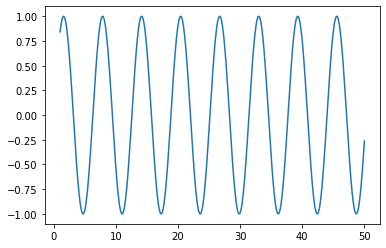

In [34]:
plt.plot(x,y)

In [41]:
len(df.loc[:5])

41

- For this sine wave use case, I think it takes approximately around 41 samples to cover at least one complete wave or one cycle
- So, we will use around 50 samples as length

In [43]:
length=50
batch_size=batch_size
generator=TimeseriesGenerator(data=train_scaled,targets=train_scaled,length=length,batch_size=batch_size)

## Creating Model

In [44]:
# import libraries
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN

In [45]:
# no. of features
n_features = 1

In [46]:
# initialize model
model = Sequential()

# add RNN layer
# units : we normally provide similar number with the length: meaning number of samples to consider
# input_shape is mandatory to pass
model.add(SimpleRNN(units=50,input_shape=(length,n_features)))

# add layer for output
model.add(Dense(1))

# compile
# loss = mse : since it is a continuous value that we are trying to predict
model.compile(optimizer='adam', loss='mse')

In [47]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 50)                2600      
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 2,651
Trainable params: 2,651
Non-trainable params: 0
_________________________________________________________________


In [48]:
# fitting the model with the TimeSeriesGenerator

model.fit_generator(generator,epochs=5)

C:\Users\budha\AppData\Local\Temp\ipykernel_9832\2845946429.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generator,epochs=5)


Epoch 1/5
201/201 [==============================] - 5s 8ms/step - loss: 0.0107
Epoch 2/5
201/201 [==============================] - 2s 8ms/step - loss: 3.1024e-04
Epoch 3/5
201/201 [==============================] - 2s 8ms/step - loss: 3.0787e-04
Epoch 4/5
201/201 [==============================] - 1s 7ms/step - loss: 5.8426e-04
Epoch 5/5
201/201 [==============================] - 1s 7ms/step - loss: 3.1822e-04


<AxesSubplot:>

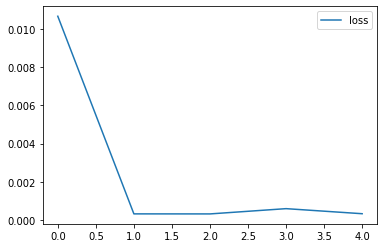

In [50]:
pd.DataFrame(model.history.history).plot()

## Evaluating the Model
- evaluating RNN model is very challenging as we will need to move forward our feature data
- Also the predicted data will be part of the feature data in the next iteration and then will be used in predicting the succeeding data

In [51]:
# first lets start with just one batch
first_eval_batch = train_scaled[-length:]

In [52]:
first_eval_batch

array([[7.58231939e-01],
       [7.15100328e-01],
       [6.69904579e-01],
       [6.23078403e-01],
       [5.75071160e-01],
       [5.26343541e-01],
       [4.77363154e-01],
       [4.28600029e-01],
       [3.80522113e-01],
       [3.33590775e-01],
       [2.88256385e-01],
       [2.44953986e-01],
       [2.04099121e-01],
       [1.66083845e-01],
       [1.31272967e-01],
       [1.00000541e-01],
       [7.25666685e-02],
       [4.92346131e-02],
       [3.02282766e-02],
       [1.57300499e-02],
       [5.87906249e-03],
       [7.69847560e-04],
       [4.51434767e-04],
       [4.92687970e-03],
       [1.41532346e-02],
       [2.80419604e-02],
       [4.64597765e-02],
       [6.92299398e-02],
       [9.61339405e-02],
       [1.26913599e-01],
       [1.61273545e-01],
       [1.98884049e-01],
       [2.39384188e-01],
       [2.82385311e-01],
       [3.27474765e-01],
       [3.74219857e-01],
       [4.22172007e-01],
       [4.70871051e-01],
       [5.19849658e-01],
       [5.68637812e-01],


- So basically we are using the last 50 samples of train scaled data 
- This will predict the first test scaled data as we have split the data from the same set

In [53]:
# check the shape of the first_eval_batch
first_eval_batch.shape

(50, 1)

- We will need to reshape our data for the model to accept and predict
- desired shape : (1,length,n_features)
- First 1 is the number of batch, second 'length' is the length of the batch or number of samples in the batch and n_features

In [55]:
first_eval_batch = first_eval_batch.reshape(1,length,n_features)

In [56]:
# check the shape of the first_eval_batch
first_eval_batch.shape

(1, 50, 1)

In [57]:
# now we can pass our input for prediction
model.predict(first_eval_batch)

1/1 [==============================] - 1s 709ms/step


array([[0.9657349]], dtype=float32)

- This basically is the predicted result and this is in scaled version.
- So, we should compare this with our first value in the scaled test data i.e. test_scaled[0]

In [58]:
test_scaled[0]

array([0.96881346])

- We are kind of doing a good job here.
- Now in order to test all the test samples, we will need to use a for loop to move our test data to acomodate the new predicted data in the test dataset and then remove the first element in the earlier test data (which is replaced by the new predicted result appended at the end of the test data)

In [59]:
# testing the append logic

new_pred = 99
first_eval_batch = train_scaled[-length:]
current_batch = first_eval_batch.reshape(1,length,n_features)

In [60]:
current_batch

array([[[7.58231939e-01],
        [7.15100328e-01],
        [6.69904579e-01],
        [6.23078403e-01],
        [5.75071160e-01],
        [5.26343541e-01],
        [4.77363154e-01],
        [4.28600029e-01],
        [3.80522113e-01],
        [3.33590775e-01],
        [2.88256385e-01],
        [2.44953986e-01],
        [2.04099121e-01],
        [1.66083845e-01],
        [1.31272967e-01],
        [1.00000541e-01],
        [7.25666685e-02],
        [4.92346131e-02],
        [3.02282766e-02],
        [1.57300499e-02],
        [5.87906249e-03],
        [7.69847560e-04],
        [4.51434767e-04],
        [4.92687970e-03],
        [1.41532346e-02],
        [2.80419604e-02],
        [4.64597765e-02],
        [6.92299398e-02],
        [9.61339405e-02],
        [1.26913599e-01],
        [1.61273545e-01],
        [1.98884049e-01],
        [2.39384188e-01],
        [2.82385311e-01],
        [3.27474765e-01],
        [3.74219857e-01],
        [4.22172007e-01],
        [4.70871051e-01],
        [5.1

- Here we can the first and last element of current_batch is 7.582 and 9.48..
- Lets see how we can append our dummy new pred, 99 at the last of this current batch and remove the first element from it

In [61]:
new_pred

99

In [63]:
current_batch = np.append(current_batch[:,1:,:],[[[new_pred]]], axis = 1)
current_batch

array([[[7.15100328e-01],
        [6.69904579e-01],
        [6.23078403e-01],
        [5.75071160e-01],
        [5.26343541e-01],
        [4.77363154e-01],
        [4.28600029e-01],
        [3.80522113e-01],
        [3.33590775e-01],
        [2.88256385e-01],
        [2.44953986e-01],
        [2.04099121e-01],
        [1.66083845e-01],
        [1.31272967e-01],
        [1.00000541e-01],
        [7.25666685e-02],
        [4.92346131e-02],
        [3.02282766e-02],
        [1.57300499e-02],
        [5.87906249e-03],
        [7.69847560e-04],
        [4.51434767e-04],
        [4.92687970e-03],
        [1.41532346e-02],
        [2.80419604e-02],
        [4.64597765e-02],
        [6.92299398e-02],
        [9.61339405e-02],
        [1.26913599e-01],
        [1.61273545e-01],
        [1.98884049e-01],
        [2.39384188e-01],
        [2.82385311e-01],
        [3.27474765e-01],
        [3.74219857e-01],
        [4.22172007e-01],
        [4.70871051e-01],
        [5.19849658e-01],
        [5.6

- Now we can see our new_pred value added at the last and the first element is removed.
- np.append(current_batch[:,1:,:],[[[new_pred]]], axis = 1)
- here in current_batch[:,1:,:] --> it means we are keeping the first element the number of samples = 1 the same
- and the last element n_features the same
- but the middle element, we are passing only the elements from 1st row to last i.e. removing the first row and appending the new pred element to the last

In [64]:
# we can use a for loop to do the same for all the samples in test data

test_predictions = []

first_eval_batch = train_scaled[-length:]
current_batch = first_eval_batch.reshape(1,length,n_features)

for i in range(len(test)):
    # get the prediction for the current batch
    pred_value = model.predict(current_batch)[0]
    
    # append the predicted value in test_predictions list
    test_predictions.append(pred_value)
    
    # update the current batch to remove the first element and add the new pred value to the last
    # beware of the braces
    
    current_batch = np.append(current_batch[:,1:,:], [[pred_value]], axis = 1)

1/1 [==============================] - 0s 23ms/step


In [65]:
# check the values for test predictions

test_predictions

[array([0.9657349], dtype=float32),
 array([0.97877127], dtype=float32),
 array([0.9857656], dtype=float32),
 array([0.9876997], dtype=float32),
 array([0.9839848], dtype=float32),
 array([0.9757794], dtype=float32),
 array([0.96258974], dtype=float32),
 array([0.9453342], dtype=float32),
 array([0.9234446], dtype=float32),
 array([0.8986561], dtype=float32),
 array([0.869863], dtype=float32),
 array([0.8387954], dtype=float32),
 array([0.80468816], dtype=float32),
 array([0.769013], dtype=float32),
 array([0.7312231], dtype=float32),
 array([0.69238144], dtype=float32),
 array([0.6522152], dtype=float32),
 array([0.61188394], dtype=float32),
 array([0.5705321], dtype=float32),
 array([0.52985275], dtype=float32),
 array([0.48864824], dtype=float32),
 array([0.44875163], dtype=float32),
 array([0.40888596], dtype=float32),
 array([0.37105957], dtype=float32),
 array([0.3339233], dtype=float32),
 array([0.29925013], dtype=float32),
 array([0.26582778], dtype=float32),
 array([0.23576139

In [66]:
# but this test_predictions are based on scaled data, so we can inverse transform this
true_predictions = scaler.inverse_transform(test_predictions)

- Now true_predictions has the predicted values in the original scale
- Now we can compare these values with our original test data

In [68]:
# we have the original test data
# we can add a column for these true predictions
test.head()

,Sine
45.198,0.937614
45.296,0.967133
45.394,0.987371
45.492,0.998134
45.590,0.999319


In [69]:
test['true_preds'] = true_predictions
test.head()

C:\Users\budha\AppData\Local\Temp\ipykernel_9832\1217403842.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['true_preds'] = true_predictions


,Sine,true_preds
45.198,0.937614,0.931457
45.296,0.967133,0.957529
45.394,0.987371,0.971518
45.492,0.998134,0.975386
45.590,0.999319,0.967957


<AxesSubplot:>

<Figure size 576x432 with 0 Axes>

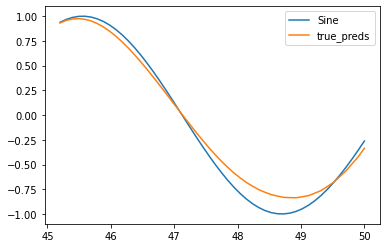

In [70]:
# now we can plot and compare between true and predicted values

plt.figure(figsize=(8,6))
test.plot()

- We can see that our predictions are doing fairy well, as it is able to mimick the sine wave nature and follows along the true sine values
- Also, the predictions are much closer at the initial data points but tends to be deviating away in the subsequent data points.
- This is because, as we go further and further, the prediction is made on the predicted data and eventually some deviation will come

## Optimize using LSTM
- Also, we will try to implement Early Stopping here

In [71]:
# import LSTM and early Stop

from tensorflow.keras.layers import LSTM
from tensorflow.keras.callbacks import EarlyStopping

In [72]:
# initialize early stop
early_stop = EarlyStopping(monitor='val_loss', patience=2)

- Now, earlier we passed only the scaled train set (as part of the generator) because we don't need the validation data to compute the loss against it for early stopping
- In order to add early stop, we will need to prepare similar generator for validation data as well
- If we do the following way, it will give error. 

In [73]:
length=50
batch_size=batch_size
generator=TimeseriesGenerator(data=test_scaled,targets=test_scaled,length=length,batch_size=batch_size)

ValueError: `start_index+length=50 > end_index=49` is disallowed, as no part of the sequence would be left to be used as current step.

- This is because we have a length of size 50 and our test data is also of length 50. 
- The generator needs at least one sample of data for validating, which means 50 - 1 = 49 (this is the minimum length of our test data that generator is expecting)
- which is less than the length (of value 50)
- so, we need at least length + 1 = 51 of test data size OR we can reduce our length size to 49, so that it match up
- To do this, we will need to create a new generator for the scaled train data as well 

In [74]:
# create new train geneator and test generator

length=49
batch_size=batch_size
train_generator=TimeseriesGenerator(data=train_scaled,targets=train_scaled,length=length,batch_size=batch_size)

test_generator=TimeseriesGenerator(data=test_scaled,targets=test_scaled,length=length,batch_size=batch_size)

In [75]:
# we will now create new model instance
# note: here we will use LSTM instead of SimpleRNN

# initialize model
model = Sequential()

# add RNN layer
# units : we normally provide similar number with the length: meaning number of samples to consider
# input_shape is mandatory to pass
model.add(LSTM(units=49,input_shape=(length,n_features)))

# add layer for output
model.add(Dense(1))

# compile
# loss = mse : since it is a continuous value that we are trying to predict
model.compile(optimizer='adam', loss='mse')

In [76]:
# now fitting the model

model.fit_generator(train_generator,
                    epochs=20, # provide more number of epochs as we have added early stop
                    validation_data=test_generator,
                    callbacks=[early_stop]
                   )

Epoch 1/20


C:\Users\budha\AppData\Local\Temp\ipykernel_9832\3494360714.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(train_generator,


201/201 [==============================] - 6s 16ms/step - loss: 0.0297 - val_loss: 4.8675e-04
Epoch 2/20
201/201 [==============================] - 3s 14ms/step - loss: 8.8142e-05 - val_loss: 2.1165e-05
Epoch 3/20
201/201 [==============================] - 3s 14ms/step - loss: 9.8811e-05 - val_loss: 1.7664e-04
Epoch 4/20
201/201 [==============================] - 3s 14ms/step - loss: 1.3502e-04 - val_loss: 1.3624e-05
Epoch 5/20
201/201 [==============================] - 3s 14ms/step - loss: 1.4608e-04 - val_loss: 7.4383e-06
Epoch 6/20
201/201 [==============================] - 3s 13ms/step - loss: 1.5195e-04 - val_loss: 7.9219e-06
Epoch 7/20
201/201 [==============================] - 3s 13ms/step - loss: 2.9533e-04 - val_loss: 2.1908e-04


<AxesSubplot:>

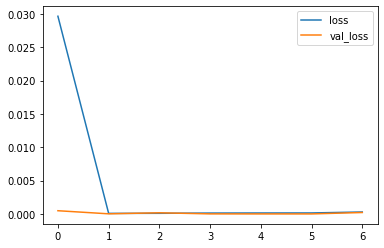

In [79]:
pd.DataFrame(model.history.history).plot()

## Evaluating the model

In [80]:
# we can use a for loop to do the same for all the samples in test data

test_predictions = []

first_eval_batch = train_scaled[-length:]
current_batch = first_eval_batch.reshape(1,length,n_features)

for i in range(len(test)):
    # get the prediction for the current batch
    pred_value = model.predict(current_batch)[0]
    
    # append the predicted value in test_predictions list
    test_predictions.append(pred_value)
    
    # update the current batch to remove the first element and add the new pred value to the last
    # beware of the braces
    
    current_batch = np.append(current_batch[:,1:,:], [[pred_value]], axis = 1)

1/1 [==============================] - 0s 21ms/step


In [82]:
true_preds = scaler.inverse_transform(test_predictions)

In [84]:
# lets add another column to the test data for this LSTM model
test['LSTM preds'] = true_preds
test.head()

C:\Users\budha\AppData\Local\Temp\ipykernel_9832\3575107731.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['LSTM preds'] = true_preds


,Sine,true_preds,LSTM preds
45.198,0.937614,0.931457,0.932925
45.296,0.967133,0.957529,0.958727
45.394,0.987371,0.971518,0.974181
45.492,0.998134,0.975386,0.979225
45.590,0.999319,0.967957,0.973942


<Figure size 720x576 with 0 Axes>

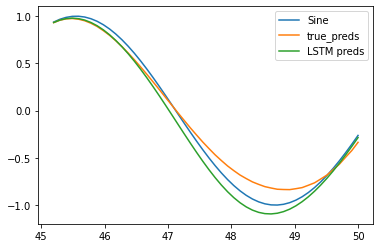

In [87]:
# plot and compare
plt.figure(figsize=(10, 8))
test.plot()
plt.show();

- Here definitely, we can little improvement in the performance from the LSTM model as compared to our earlier model, normal RNN model

## Forecast

- Now lets say, we are happy with our model performance and ready to use it for forecasting
- For this, we will create a new model using all the data in our dataset

In [88]:
# we have our df
df.head()

,Sine
1.000,0.841471
1.098,0.890298
1.196,0.930582
1.294,0.961936
1.392,0.984058


In [89]:
# first lets scaled our full data
full_scaler = MinMaxScaler()
full_scaler.fit(df)

MinMaxScaler()

In [90]:
# create a full scaled data
full_scaled_data = full_scaler.transform(df) 

In [94]:
# now create the generator with the all these data
length = 50
batch_size = 1
final_generator = TimeseriesGenerator(full_scaled_data, full_scaled_data, length=length, batch_size=batch_size)

In [96]:
# create the model and train with these new full data

# we will now create new model instance
# note: here we will use LSTM instead of SimpleRNN

# initialize model
model = Sequential()

# add RNN layer
# units : we normally provide similar number with the length: meaning number of samples to consider
# input_shape is mandatory to pass
model.add(LSTM(units=50,input_shape=(length,n_features)))

# add layer for output
model.add(Dense(1))

# compile
# loss = mse : since it is a continuous value that we are trying to predict
model.compile(optimizer='adam', loss='mse')

In [97]:
# fit model

model.fit_generator(final_generator,
                    epochs=7  # as the last model was trained using 7 epochs
                   )

Epoch 1/7


C:\Users\budha\AppData\Local\Temp\ipykernel_9832\1667725908.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(final_generator,


451/451 [==============================] - 7s 12ms/step - loss: 0.0197
Epoch 2/7
451/451 [==============================] - 5s 11ms/step - loss: 4.3806e-04
Epoch 3/7
451/451 [==============================] - 5s 12ms/step - loss: 1.2995e-04
Epoch 4/7
451/451 [==============================] - 6s 12ms/step - loss: 6.8818e-05
Epoch 5/7
451/451 [==============================] - 5s 12ms/step - loss: 2.4107e-04
Epoch 6/7
451/451 [==============================] - 5s 11ms/step - loss: 2.1926e-04
Epoch 7/7
451/451 [==============================] - 5s 12ms/step - loss: 2.1859e-04


**Now this time we will be forecasting the future sine wave values, lets say we will try to predict for the next 25 data points** 

In [98]:
# we can use a for loop to do the same for all the samples in test data

forecast = []

first_eval_batch = train_scaled[-length:]
current_batch = first_eval_batch.reshape(1,length,n_features)

for i in range(25): # will predict for next 25 data points
    
    # get the prediction for the current batch
    pred_value = model.predict(current_batch)[0]
    
    # append the predicted value in test_predictions list
    forecast.append(pred_value)
    
    # update the current batch to remove the first element and add the new pred value to the last
    # beware of the braces
    
    current_batch = np.append(current_batch[:,1:,:], [[pred_value]], axis = 1)

1/1 [==============================] - 0s 18ms/step


In [100]:
# now we have our forecasted values
# we will need to scaled it back to the original format

forecast = full_scaler.inverse_transform(forecast)

- Now in order to plot these forcasted values, we will need to create index for these values

In [101]:
df.tail()

,Sine
49.608,-0.611126
49.706,-0.530748
49.804,-0.445276
49.902,-0.355531
50.000,-0.262375


- We know index of our train data goes is upto 50.00 and also it has a step size of 0.1
- So, we will need to calculate the next 25 points with this step size starting from 50.01

In [102]:
# calculate upto how many points to go
0.1 * 25

2.5

In [105]:
np.arange(50.1, (50.1 + 2.5), step = 0.1)

array([50.1, 50.2, 50.3, 50.4, 50.5, 50.6, 50.7, 50.8, 50.9, 51. , 51.1,
       51.2, 51.3, 51.4, 51.5, 51.6, 51.7, 51.8, 51.9, 52. , 52.1, 52.2,
       52.3, 52.4, 52.5])

In [106]:
# forecast index
forecast_index = np.arange(50.1, (50.1 + 2.5), step = 0.1)
len(forecast_index)

25

In [107]:
# predicted values length
len(forecast)

25

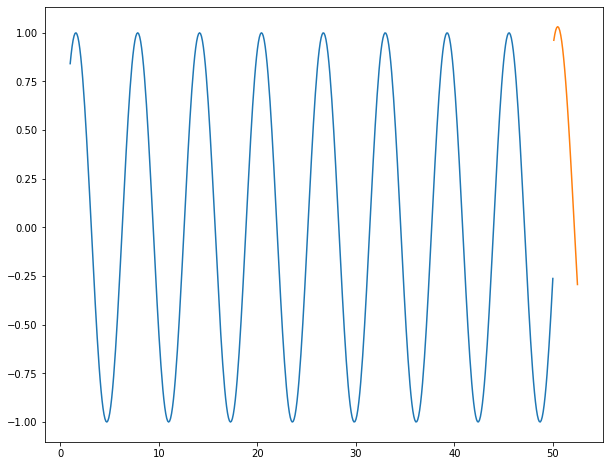

In [110]:
# now we can plot and check

plt.figure(figsize = (10, 8))
plt.plot(df.index, df)
plt.plot(forecast_index, forecast)
plt.show();

In [113]:
df.head()

,Sine
1.000,0.841471
1.098,0.890298
1.196,0.930582
1.294,0.961936
1.392,0.984058


In [115]:
## also we can concatenate these two data and then plot
forecast_df = pd.DataFrame(data=forecast, index = forecast_index, columns = ['Sine'])
forecast_df.head()

,Sine
50.1,0.961692
50.2,0.992271
50.3,1.014398
50.4,1.027510
50.5,1.031426


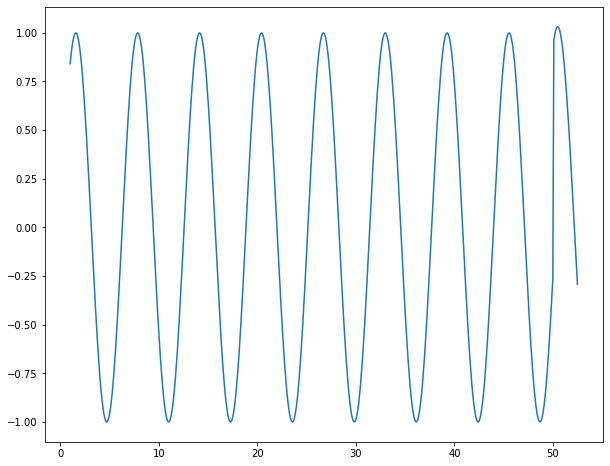

In [120]:
# concat and plot
plt.figure(figsize=(10,8))
plt.plot(pd.concat([df, forecast_df]))
plt.show();